# Feature Evolution with Phase

This notebook explores the evolution of feature properties (e.g., pEW and velocities) as a function of phase.


In [1]:
from collections import OrderedDict
from pathlib import Path
from warnings import warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.cosmology import WMAP9 as wmap9
from matplotlib.ticker import MultipleLocator
from scipy.stats.stats import pearsonr
from sndata.csp import DR3
from sndata.sdss import Sako18Spec
from sndata.utils import convert_to_jd

from utils import read_in_pipeline_result, feature_alias


In [2]:
DR3().download_module_data()
Sako18Spec().download_module_data()

results_dir = Path('.').resolve().parent / 'results'
csp_final = read_in_pipeline_result(results_dir / 'final_csp.csv', 'csp', drop_flagged=True)
sdss_final = read_in_pipeline_result(results_dir / 'final_sdss.csv', 'sdss', drop_flagged=True)


## Plotting Logic

In [3]:
def plot_feat_evolution(feature_data, plot_col='pew', color_by='spec_type', kwargs=None, axis=None):
    """Plot the strength of a feature vs phase
    
    Args:
        feature_data (DataFrame): Dataframe to plot data from
        plot_col           (str): Column to plot on the y axis 
        color_by           (str): Name of the column to color code points by
        kwargs      (dict[dict]): Plotting kwargs for each unique value in the `color_by` column
        axis              (Axis): Optionally plot on a given axis
    """

    # Set default values
    kwargs = dict() if kwargs is None else kwargs
    if axis is None:
        fig, axis = plt.subplots(figsize=(6, 4))
    
    feature_data = feature_data.sort_values('phase')
    for i, (class_name, class_data) in enumerate(feature_data.groupby(color_by)):
        x = class_data.phase
        y = class_data[plot_col]
        y_err = class_data[plot_col + '_samperr']
        
        plot_kw = kwargs.get(class_name, dict())
        axis.errorbar(x, y, yerr=y_err, linestyle='', **plot_kw)
        axis.scatter(x, y, s=10, label=class_name,  **plot_kw)
    
    if axis is None:
        axis.set_xlabel('Phase', fontsize=12)
        axis.set_ylabel(r'pEW ($\AA$)', fontsize=12)
        
    axis.set_xlim(-15, 15)
    

In [4]:
def plot_all_features(df, plot_col='pew', color_by='spec_type', kwargs=None):
    """Plot pEW measurements vs. phase for all 8 features
    
    Args:
        df      (DataFrame): Dataframe to plot data from
        plot_col      (str): Column to plot on the y axis
        color_by      (str): Name of the column to color code points by
        kwargs (dict[dict]): Plotting kwargs for each unique value in the `color_by` column
    """

    # Set default values
    kwargs = dict() if kwargs is None else kwargs
    plot_features = feature_alias.copy()
    
    fig, axes = plt.subplots(4, 2, sharex=True, figsize=(7.5, 10))
    for axis, feature in zip(axes.flatten(), plot_features):
        axis.set_title(f'{plot_features[feature]} ({feature})')

        feature_data = df.loc[feature]
        plot_feat_evolution(
            feature_data, plot_col=plot_col,
            color_by=color_by, axis=axis, kwargs=kwargs)
        
    for axis in axes[:, 0]:
        axis.set_ylabel(plot_col, fontsize=12)
    
    for axis in axes[-1, :]:
        axis.set_xlabel('Phase', fontsize=12)
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), framealpha=1, bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout()
    

## CSP

In [5]:
csp_kwargs = {
    'normal': {'color': 'grey', 'alpha': .3},
    '91bg-like': {'color': 'C3'},
    '91T-like': {'color': 'C0'},
    '06gz-like': {'color': 'C1'}
}


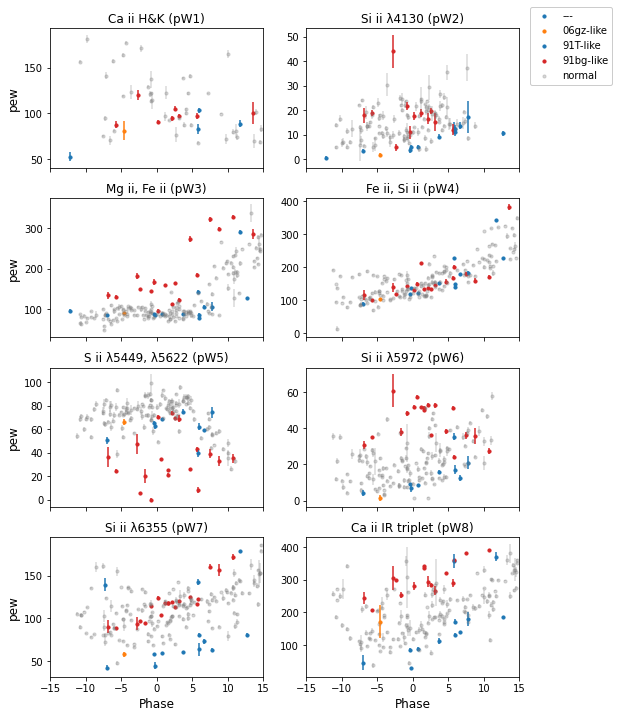

In [6]:
plot_all_features(csp_final, kwargs=csp_kwargs, color_by='spec_type')


/home/djperrefort/miniconda3/envs/SN-Spectral-Evolution/lib/python3.7/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


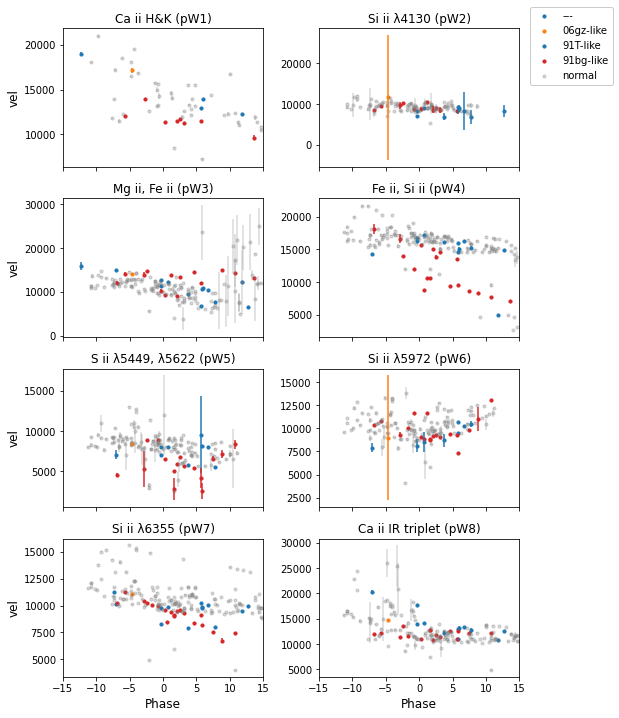

In [7]:
plot_all_features(csp_final, 'vel',  kwargs=csp_kwargs, color_by='spec_type')


## SDSS

In [8]:
sdss_kwargs = {
    'BL': {'color': 'red', 'alpha': .5},
    'SS': {'color':'green', 'alpha': .5},
    'CL':{'color':'blue', 'alpha': .5},
    'CN':{'color':'black', 'alpha': .5},
    'unknown': {'color': 'grey', 'alpha': .3}
}


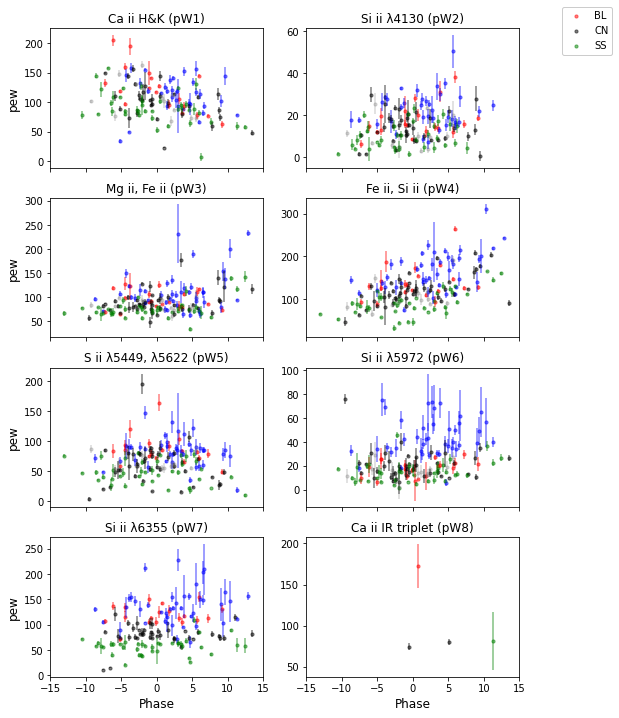

In [9]:
plot_all_features(sdss_final, kwargs=sdss_kwargs, color_by='branch_type')


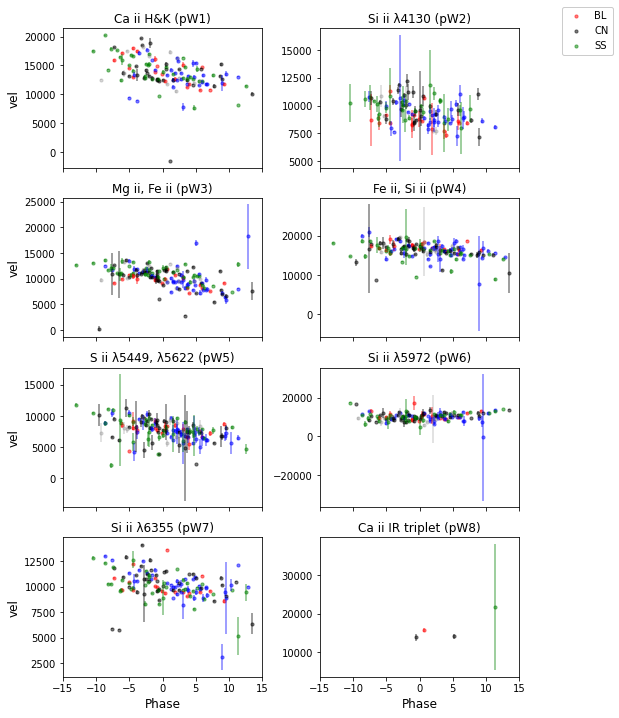

In [10]:
plot_all_features(sdss_final, 'vel', kwargs=sdss_kwargs, color_by='branch_type')
